In [1]:
from IPython.display import Image

In [9]:
#Import all the necessary libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import re
import plotly.express as px
from collections import defaultdict
from scipy.signal import find_peaks


In [3]:
###Importing Variables for all functions

data_base_name_location = 'lipid_database/Lipid_Database.xlsx'####Lipid database with Standard Carnitines
mzml_folder = './data_mzml/04-29-2023_mzml/test_oz_1/'
tolerance = 0.3
remove_std = True

# Example usage:
folder_name_to_save = 'TEST_04-29-2023_validation_test_1'
file_name_to_save = 'TEST_04-29-2023_validation_test_1'
save_data= True





In [19]:

###All functions

#Function to read in MRM database
#Option to remove STDs from database##Not finished need option to use another database with no qualitative ACs


def read_mrm_list(filename,remove_std = True):
    mrm_list_new = pd.read_excel(filename, sheet_name=None)
    mrm_list_new = pd.concat(mrm_list_new, ignore_index=True)
    mrm_list_offical = mrm_list_new[['Compound Name', 'Parent Ion', 'Product Ion', 'Class']]
    # Add underscore to middle of columns names
    mrm_list_offical.columns = mrm_list_offical.columns.str.replace(' ', '_')
    # Round Parent Ion and Product Ion to 1 decimal place
    mrm_list_offical['Parent_Ion'] = np.round(mrm_list_offical['Parent_Ion'],1)
    mrm_list_offical['Product_Ion'] = np.round(mrm_list_offical['Product_Ion'],1)
    # Create transition column by combining Parent Ion and Product Ion with arrow between numbers
    mrm_list_offical['Transition'] = mrm_list_offical['Parent_Ion'].astype(str) + ' -> ' + mrm_list_offical['Product_Ion'].astype(str)
    # Change column compound name to lipid
    mrm_list_offical = mrm_list_offical.rename(columns={'Compound_Name': 'Lipid'})
    # Make a column called Class match lipid column to lipid types
    if remove_std == True:
        lipid_class = mrm_list_offical['Class'].unique()
        lipid_class_to_keep = ['PS','PG','CE','PC', 'DAG', 'PE', 'TAG', 'FA', 'Cer', 'CAR', 'PI','SM']
        mrm_list_offical = mrm_list_offical[mrm_list_offical['Class'].isin(lipid_class_to_keep)]
    return mrm_list_offical

#OzESI
OzESI_time = {}
def mzml_parser(file_name):
    df = pd.DataFrame(columns=['Lipid','Parent_Ion','Product_Ion','Intensity','Transition','Class','Sample_ID'])
    data_folder = os.listdir(file_name) #Path to the mzml files
    data_folder.sort()
    path_to_mzml_files = file_name

    
    

    for file in data_folder:
            if file.endswith('.mzML'):

                    run = pymzml.run.Reader(path_to_mzml_files+file, skip_chromatogram=False) #Load the mzml file into the run object



                    df_all = pd.DataFrame(columns=['Lipid','Parent_Ion','Product_Ion','Intensity','Transition','Class','Sample_ID']) #Create empty pandas dataframe to store the data

                    #create pandas dataframe to store the data with the columns Parent Ion, Product Ion, Intensity, Transition Lipid and Class
                   
                    q1_mz = 0 #Create empty variables to store the Q1 and Q3 m/z values
                    q3_mz = 0
                    count = 0 #Create a counter to keep track of the number of transitions
                    for spectrum in run:
                        if isinstance(spectrum, pymzml.spec.Chromatogram):
                            for time, intensity in spectrum.peaks():
                                OzESI_time[time] = np.round(intensity), q1_mz, q3_mz

                            for element in spectrum.ID.split(' '):
                                    intensity_store = np.array([])
                                    if 'Q1' in element:
                                            q1 = element.split('=')
                                            q1_mz= np.round((float(q1[1])),1)

                                    if 'Q3' in element:
                                
                                            q3 = element.split('=')
  
                                            q3_mz=np.round(float(q3[1]),1)


                                            for mz,intensity in spectrum.peaks(): #Get the m/z and intensity values from the spectrum
                                                    intensity_store = np.append(intensity_store,intensity) #Store the intensity values in an array



                                    if 'Q3' in element:
                                            # print(intensity_sum)
                                            intensity_sum = np.sum(intensity_store) #Sum the intensity values
                                            df_all.loc[count,'Parent_Ion'] = q1_mz #Store the Q1 and Q3 m/z values in the pandas dataframe
                                            df_all.loc[count,'Product_Ion'] = q3_mz
                                            #round the Q1 and Q3 m/z values to 1 decimal places
                                            df_all.loc[count,'Parent_Ion'] = np.round(df_all.loc[count,'Parent_Ion'],1)
                                            df_all.loc[count,'Product_Ion'] = np.round(df_all.loc[count,'Product_Ion'],1)
                                            df_all.loc[count,'Intensity'] = intensity_sum #Store the intensity values in the pandas dataframe
                                            df_all.loc[count,'Transition'] = str(q1_mz)+ ' -> '+ str(q3_mz) #Store the transition values in the pandas dataframe
                                            #add file name to Sample_ID column without the mzmL extension
                                            df_all.loc[count,'Sample_ID'] = file[:-5]
                                            count+=1

            #append df_all to df
            df = df.append(df_all, ignore_index=True)
    return df

# Function to create an ion dictionary from an MRM database DataFrame
def create_ion_dict(mrm_database):
    ion_dict = defaultdict(list)
    # Iterate through the rows of the MRM database DataFrame
    for index, row in mrm_database.iterrows():
        # Add a tuple with Lipid and Class to the ion dictionary using Parent_Ion and Product_Ion as the key
        ion_dict[(row['Parent_Ion'], row['Product_Ion'])].append((row['Lipid'], row['Class']))
    return ion_dict

# Function to check if the absolute difference between two values is within a given tolerance
def within_tolerance(a, b, tolerance=0.1):
    return abs(a - b) <= tolerance

# Function to match the ions in a DataFrame row with the ions in an ion dictionary
def match_ions(row, ion_dict, tolerance=0.1):
    ions = (row['Parent_Ion'], row['Product_Ion'])
    matched_lipids = []
    matched_classes = []

    # Iterate through the ion dictionary
    for key, value in ion_dict.items():
        # Check if both the Parent_Ion and Product_Ion values are within the specified tolerance
        if within_tolerance(ions[0], key[0], tolerance) and within_tolerance(ions[1], key[1], tolerance):
            # If within tolerance, extend the matched_lipids and matched_classes lists with the corresponding values
            matched_lipids.extend([match[0] for match in value])
            matched_classes.extend([match[1] for match in value])

    # If any matches were found, update the Lipid and Class columns in the row
    if matched_lipids and matched_classes:
        row['Lipid'] = ' | '.join(matched_lipids)
        row['Class'] = ' | '.join(matched_classes)

    return row

####Combined functions for Matching

def match_lipids_parser(mrm_database,df, tolerance=0.3):
    ion_dict = create_ion_dict(mrm_database)
    # Assuming you have the df DataFrame to apply the match_ions function
    df_matched = df.apply(lambda row: match_ions(row, ion_dict=ion_dict, tolerance=tolerance), axis=1)


    # df_matched = df_matched.dropna()
    
    return df_matched


def save_dataframe(df, folder_name, file_name, max_attempts=5):
    folder_path = f'data_results/data/data_matching/{folder_name}'
    os.makedirs(folder_path, exist_ok=True)

    for i in range(max_attempts):
        file_path = f'{folder_path}/{file_name}.csv'
        if not os.path.isfile(file_path):
            df.to_csv(file_path, index=False)
            print(f"Saved DataFrame to {file_path}")
            break
    else:
        print(f"Failed to save DataFrame after {max_attempts} attempts.")
        return None


def full_parse(data_base_name_location,mzml_folder, folder_name_to_save, file_name_to_save,tolerance,remove_std = True,
               save_data=False):
    mrm_database = read_mrm_list(data_base_name_location,remove_std=remove_std)
    df = mzml_parser(mzml_folder)
    df_matched = match_lipids_parser(mrm_database,df, tolerance=tolerance)
    
    if save_data == True:
        
        save_dataframe(df_matched, folder_name_to_save, file_name_to_save)

    return df_matched





In [20]:
df_matched = full_parse(data_base_name_location,mzml_folder, folder_name_to_save, 
                        file_name_to_save,tolerance, remove_std = remove_std,save_data=save_data)



/tmp/ipykernel_25991/2674365659.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrm_list_offical['Parent_Ion'] = np.round(mrm_list_offical['Parent_Ion'],1)
/tmp/ipykernel_25991/2674365659.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrm_list_offical['Product_Ion'] = np.round(mrm_list_offical['Product_Ion'],1)
/tmp/ipykernel_25991/2674365659.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Failed to save DataFrame after 5 attempts.


/tmp/ipykernel_25991/2674365659.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_all, ignore_index=True)


In [23]:
print(df_matched.head())
#print first 5 values of OzESI_time
print(list(OzESI_time.items())[:5])

  Lipid  Parent_Ion  Product_Ion     Intensity      Transition Class  \
0   NaN       694.6        547.6  2.567996e+05  694.6 -> 547.6   NaN   
1   NaN       696.6        549.6  2.185144e+05  696.6 -> 549.6   NaN   
2   NaN       698.7        551.6  6.608002e+06  698.7 -> 551.6   NaN   
3   NaN       720.6        573.6  7.330655e+04  720.6 -> 573.6   NaN   
4   NaN       722.6        575.6  1.428391e+05  722.6 -> 575.6   NaN   

                          Sample_ID  
0  DOD93_F4-5xFAD-Cereb_TG18-1_o3on  
1  DOD93_F4-5xFAD-Cereb_TG18-1_o3on  
2  DOD93_F4-5xFAD-Cereb_TG18-1_o3on  
3  DOD93_F4-5xFAD-Cereb_TG18-1_o3on  
4  DOD93_F4-5xFAD-Cereb_TG18-1_o3on  
[(0.00011666666666666667, (151.0, 900.8, 601.6)), (0.0035, (150.0, 898.8, 599.6)), (0.006883333333333333, (244.0, 876.8, 577.6)), (0.010283333333333334, (185.0, 874.8, 575.6)), (0.013666666666666667, (165.0, 872.8, 573.6))]


In [122]:


def process_chromatogram(OzESI_time):
    # Create dataframe from OzESI_time dictionary
    OzESI_rt_df = pd.DataFrame(list(OzESI_time.items()), columns=['Retention_Time', 'intensity'])
    
    # Split intensity column into three columns intensity, Parent_Ion and Product_Ion
    OzESI_rt_df[['intensity','Parent_Ion','Product_Ion']] = pd.DataFrame(OzESI_rt_df['intensity'].tolist(), index=OzESI_rt_df.index)
    
    # Round retention Retention_Time to 1 decimal place
    OzESI_rt_df['Retention_Time'] = round(OzESI_rt_df['Retention_Time'], 2)
    
    # Create a column called Transition with the Parent_Ion and Product_Ion
    OzESI_rt_df['Transition'] = OzESI_rt_df['Parent_Ion'].astype(str) + ' -> ' + OzESI_rt_df['Product_Ion'].astype(str)
    
    ########### HARDCODED TO DROP RETENTION TIMES BELOW 7 SECONDS ############
    #drop Rention_Time below 10.5 seconds and above 15.5 seconds
    OzESI_rt_df = OzESI_rt_df[OzESI_rt_df['Retention_Time'] > 10.5]
    OzESI_rt_df = OzESI_rt_df[OzESI_rt_df['Retention_Time'] < 15.5]

    # Get the top 10 records for each 'Transition' based on 'intensity'
    OzESI_rt_df_top = OzESI_rt_df.groupby('Transition').apply(lambda x: x.nlargest(10, 'intensity')).reset_index(drop=True)

    print('OzESI 10 largest per transition: \n', OzESI_rt_df_top)

    # peaks, _ = find_peaks(OzESI_rt_df['intensity'], height=0.5e5,distance=1000)
    # plt.scatter(OzESI_rt_df['Retention_Time'] ,OzESI_rt_df['intensity'])
    # plt.scatter(OzESI_rt_df.iloc[peaks]['Retention_Time'], OzESI_rt_df.iloc[peaks]['intensity'], "x")
    # plt.ylabel('Intensity')
    # plt.xlabel('Retention Time')
    # plt.title('OzESI LC Chromatogram')
    # plt.show()
    
    return OzESI_rt_df_top


#     print(list(OzESI_time.items())[:5])
#     df_OzESI_time = pd.DataFrame(list(OzESI_time.items()), columns=['Time', 'Intensity'])
#     print('11111\n',df_OzESI_time.head())
#     #convert intensity column to a string
#     df_OzESI_time['Intensity'] = df_OzESI_time['Intensity'].astype(str)
#     # Split the 'Intensity' column into three new columns
#     df_OzESI_time[['Intensity', 'Parent_Ion', 'Product_Ion']] = df_OzESI_time['Intensity'].str.strip('()').str.split(',', expand=True).astype(float)
#     #Convert Intensity_1, Parent_Ion and Product_Ion to float
#     print('222222\n',df_OzESI_time.head())
#     df_OzESI_time['Intensity'] = df_OzESI_time['Intensity'].astype(float)

#     #convert Product_Ion and Parent_Ion to string with -> in between
#     df_OzESI_time['Product_Ion'] = df_OzESI_time['Product_Ion'].astype(str)
#     df_OzESI_time['Parent_Ion'] = df_OzESI_time['Parent_Ion'].astype(str)
#     df_OzESI_time['Transition'] = df_OzESI_time['Parent_Ion'].str.cat(df_OzESI_time['Product_Ion'],sep=' -> ')
#     df_OzESI_time['Parent_Ion'] = df_OzESI_time['Parent_Ion'].astype(float)
#     df_OzESI_time['Product_Ion'] = df_OzESI_time['Product_Ion'].astype(float)
    
#     #sort the dataframe by transition
#     df_OzESI_time.sort_values(by=['Transition'], inplace=True)
    
#     df_2 = pd.DataFrame(columns=['Intensity', 'Retention_Time', 'Transition'])
#     # Extract the intensity values from the DataFrame
#     intensity_values = df_OzESI_time['Intensity'].values
    
#     # Find peaks in the intensity values
#     peaks, _ = find_peaks(intensity_values)
#     print('4444\n',df_OzESI_time.head())
#     # Get the peak values, time points, and transitions
#     peak_values = intensity_values[peaks]
#     print('5555\n',df_OzESI_time.head())
#     time_points = df_OzESI_time['Time'].values[peaks]
#     print('6666\n',df_OzESI_time.head())
#     transitions = df_OzESI_time['Transition'].values[peaks]
#     print('77777\n',df_OzESI_time.head())
    
#     # Create a new DataFrame to store the peak information
#     peak_df = pd.DataFrame({
#         'Peak Value': peak_values,
#         'Retention_Time': time_points,
#         'Transition': transitions
#     })
    
#     # Print the peaks and their corresponding time points
#     for _, row in peak_df.iterrows():
#         #print(f"Peak value: {row['Peak Value']}, Time: {row['Time']}, Transition: {row['Transition']}")
#         df_2 = df_2.append({'Intensity': row['Peak Value'], 'Retention_Time': row['Retention_Time'], 'Transition': row['Transition']}, ignore_index=True)

#     #sort the dataframe by transition
#     df_2.sort_values(by=['Transition'], inplace=True)
#     # Create dataframe from OzESI_rt_df
#     OzESI_rt_df = df_2

#     # Round retention Retention_Time to 1 decimal place
#     OzESI_rt_df['Retention_Time'] = round(OzESI_rt_df['Retention_Time'], 2)
    
#     # Create a column called Transition with the Parent_Ion and Product_Ion
#     OzESI_rt_df['Transition'] = OzESI_rt_df['Parent_Ion'].astype(str) + ' -> ' + OzESI_rt_df['Product_Ion'].astype(str)
    
# #     ########### HARDCODED TO DROP RETENTION TIMES BELOW 7 SECONDS ############
#     #drop Rention_Time below 10.5 seconds and above 15.5 seconds
#     OzESI_rt_df = OzESI_rt_df[OzESI_rt_df['Retention_Time'] > 10.5]
#     OzESI_rt_df = OzESI_rt_df[OzESI_rt_df['Retention_Time'] < 15.5]

#     # Sort the DataFrame by intensity in descending order
#     OzESI_rt_df_sorted = OzESI_rt_df.sort_values(['intensity'], ascending=False)
#     # Group the DataFrame by 'Parent_Ion' and 'Product_Ion'
#     grouped_df = OzESI_rt_df_sorted.groupby(['Parent_Ion', 'Product_Ion'])

#     # Create an empty DataFrame to store the top 5 values
#     top_5_df = pd.DataFrame(columns=OzESI_rt_df.columns)

#     # Iterate over each group
#     for _, group in grouped_df:
#         # Get the top 5 rows with the highest intensity
#         top_5_rows = group.head(5)
#         # Append the top 5 rows to the 'top_5_df'
#         top_5_df = top_5_df.append(top_5_rows)

#     # Sort the 'top_5_df' by the original index
#     top_5_df.sort_index(inplace=True)

# # Print the DataFrame with the top 5 values for each 'Parent_Ion' and 'Product_Ion'
#     print('here is top 5\n',top_5_df)
#     OzESI_rt_df_top = top_5_df.nlargest(1000, 'intensity')
#     #OzESI_rt_df_top = OzESI_rt_df_sorted.nlargest(1000, 'intensity')

#     print('OzESI 10 largest: \n', OzESI_rt_df_top)
    
# Find peaks in the intensity column and plot the chromatogram
    # peaks, _ = find_peaks(OzESI_rt_df['intensity'], height=0.5e5,distance=1000)
    # plt.plot(OzESI_rt_df['Retention_Time'] ,OzESI_rt_df['intensity'])
    # plt.plot(OzESI_rt_df.iloc[peaks]['Retention_Time'], OzESI_rt_df.iloc[peaks]['intensity'], "x")
    # plt.ylabel('Intensity')
    # plt.xlabel('Retention Time')
    # plt.title('OzESI LC Chromatogram')
    # plt.show()
    
#     #return OzESI_rt_df_top

######### OLD CODE##############
# def add_rt_intensity(df, OzESI_rt_df_top):
#     # Create a dictionary to map transitions to retention times and intensities
#     transitions_to_rt = dict(zip(OzESI_rt_df_top['Transition'], OzESI_rt_df_top['Retention_Time']))
#     transitions_to_intensity = dict(zip(OzESI_rt_df_top['Transition'], OzESI_rt_df_top['intensity']))
#     # Use the map function to add retention times and intensities to the dataframe
#     df['Retention_Time'] = df['Transition'].map(transitions_to_rt)
#     df['Intensity_OzESI'] = df['Transition'].map(transitions_to_intensity)
    
#     return df

# def add_rt_intensity(df, OzESI_rt_df_top):
#     # Initialize an empty DataFrame to store the results
#     new_df = pd.DataFrame()

#     # Group by 'Transition' and iterate over the groups
#     for name, group in OzESI_rt_df_top.groupby('Transition'):
#         # Keep the top 10 values for each transition
#         top_values = group.nlargest(10, 'intensity')

#         # Append the top values DataFrame to the results DataFrame
#         new_df = new_df.append(top_values, ignore_index=True)

#     # Create dictionaries to map transitions to retention times and intensities
#     transitions_to_rt = dict(zip(new_df['Transition'], new_df['Retention_Time']))
#     transitions_to_intensity = dict(zip(new_df['Transition'], new_df['intensity']))

#     # Use the map function to add retention times and intensities to the dataframe
#     df['Retention_Time'] = df['Transition'].map(transitions_to_rt)
#     df['Intensity_OzESI'] = df['Transition'].map(transitions_to_intensity)

#     return df
def add_rt_intensity(df, OzESI_rt_df_top):

    #### STRING OF RETENTION TIMES
    # Group by 'Transition' and get lists of retention times and intensities
    transitions_to_rt = OzESI_rt_df_top.groupby('Transition')['Retention_Time'].apply(list).to_dict()
    transitions_to_intensity = OzESI_rt_df_top.groupby('Transition')['intensity'].apply(list).to_dict()
    
    # Use the map function to add retention times and intensities to the dataframe as strings
    df['Retention_Time'] = df['Transition'].map(transitions_to_rt).apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else x)
    df['Intensity_OzESI'] = df['Transition'].map(transitions_to_intensity).apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else x)
    

    #MEAN OF RENETION TIMES
    # Convert the 'Retention_Time' column from string of lists to lists of floats
    df['Retention_Time'] = df['Retention_Time'].apply(lambda x: [float(i) for i in x.split(', ')] if isinstance(x, str) else x)

    # Calculate the mean of 'Retention_Time' for each transition
    df['Mean_Retention_Time'] = df['Retention_Time'].apply(np.mean)

    # Convert the 'Intensity_OzESI' column from string of lists to lists of floats
    df['Intensity_OzESI'] = df['Intensity_OzESI'].apply(lambda x: [float(i) for i in x.split(', ')] if isinstance(x, str) else x)

    # Calculate the mean of 'Intensity_OzESI' for each transition
    df['Mean_Intensity_OzESI'] = df['Intensity_OzESI'].apply(np.mean)

    return df


def create_aldehyde_ion_dataframe():
    # Create a pandas dataframe with columns for DB_Position and Aldehyde_Ion
    df_OzESI = pd.DataFrame(columns=['DB_Position','Aldehyde_Ion'])

    # Loop over the range of DB_Position values and calculate the corresponding Aldehyde_Ion values
    for i in range(3, 21):
        df_OzESI.loc[i,'DB_Position'] = i
        df_OzESI.loc[i,'Aldehyde_Ion'] = 26 + (14 * (i-3)) 

    # Print the first 25 rows of the dataframe
    # print(df_OzESI.head(25))

    # Return the dataframe
    return df_OzESI

#OzESI_list = [3,5,7,9,11]
OzESI_list = [7,9,12]
#def calculate_n_minus_values(df_matched, df_OzESI, OzESI_list=[3,5,7,9,11], starting_column=9, last_column=14):
def calculate_n_minus_values(df_matched, df_OzESI, OzESI_list=[7,9,12], starting_column=9, last_column=14):
    """
    Given a pandas dataframe df and a dataframe df_OzESI containing DB_Position and Aldehyde_Ion values,
    calculates the n-i values for each i in OzESI_list by subtracting the corresponding Aldehyde_Ion value
    from the Parent_Ion column in df and storing the result in new columns named 'n-i' in df.
    The starting_column and last_column parameters specify the range of columns in which the n-i values should be stored.
    """
    # Create new columns in df for n-i values
    for i in OzESI_list:
        df_matched[f"n-{i}"] = df_matched["Parent_Ion"] - df_OzESI.loc[df_OzESI["DB_Position"] == i, "Aldehyde_Ion"].values[0]
    
    # Print the shape of the dataframe and return it
    # print(df_matched.shape)
    return df_matched


# OzESI_rt_df_top = process_chromatogram(OzESI_time)


OzESI 10 largest per transition: 
      Retention_Time   intensity  Parent_Ion  Product_Ion      Transition
0             11.69      3903.0         0.0          0.0      0.0 -> 0.0
1             11.57      1849.0         0.0          0.0      0.0 -> 0.0
2             11.81      1517.0         0.0          0.0      0.0 -> 0.0
3             11.94      1386.0         0.0          0.0      0.0 -> 0.0
4             12.18      1227.0         0.0          0.0      0.0 -> 0.0
..              ...         ...         ...          ...             ...
345           15.49  49839999.0       902.8        603.6  902.8 -> 603.6
346           15.49  49838501.0       902.8        603.6  902.8 -> 603.6
347           15.49  49835999.0       902.8        603.6  902.8 -> 603.6
348           15.49  49832001.0       902.8        603.6  902.8 -> 603.6
349           15.49  49827499.0       902.8        603.6  902.8 -> 603.6

[350 rows x 5 columns]


ValueError: s must be a scalar, or float array-like with the same size as x and y

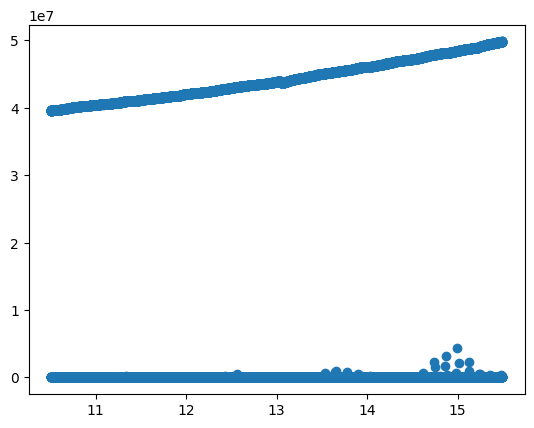

In [123]:
#OzESI_list = [3,5,7,9,11]
#def df_OzESI_pipeline(df, OzESI_time, OzESI_list=[3,5,7,9,12]):
def df_OzESI_pipeline(df, OzESI_time, OzESI_list=[7,9,12]):
    # Process chromatogram
    OzESI_rt_df_top = process_chromatogram(OzESI_time)
    
    df_OzESI = create_aldehyde_ion_dataframe()
    # Add retention time and intensity to dataframe
    df_processed = add_rt_intensity(df, OzESI_rt_df_top)
    # Calculate n-minus values
    df_processed = calculate_n_minus_values(df_processed, df_OzESI, OzESI_list, starting_column=9, last_column=14)
    
    return df_processed
df_OzESI_processed = df_OzESI_pipeline(df_matched, OzESI_time)
df_OzESI_processed.tail(10)

In [71]:
df_OzESI_processed.head(None)

,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI,n-7,n-9,n-12,Mean_Retention_Time,Mean_Intensity_OzESI
0,NaN,694.6,547.6,2.567996e+05,694.6 -> 547.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.91, 12.79, 13.03, 12.66, 13.39, 13.52, 13....","[18586.0, 9281.0, 4929.0, 4516.0, 4198.0, 3581...",612.6,584.6,542.6,12.895,5906.9
1,NaN,696.6,549.6,2.185144e+05,696.6 -> 549.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[14.0, 14.12, 14.24, 13.88, 13.27, 13.63, 13.7...","[59211.0, 34814.0, 30287.0, 24331.0, 23284.0, ...",614.6,586.6,544.6,13.890,27905.7
2,NaN,698.7,551.6,6.608002e+06,698.7 -> 551.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.63, 12.05, 11.93, 12.17, 14.24, 11.56, 14....","[590.0, 572.0, 571.0, 559.0, 545.0, 539.0, 530...",616.7,588.7,546.7,13.267,545.7
3,NaN,720.6,573.6,7.330655e+04,720.6 -> 573.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.77, 12.65, 12.9, 13.38, 11.92, 13.02, 13.1...","[3643.0, 2200.0, 2173.0, 1857.0, 1720.0, 1517....",638.6,610.6,568.6,12.810,1839.9
4,NaN,722.6,575.6,1.428391e+05,722.6 -> 575.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.99, 13.87, 13.02, 14.11, 13.14, 14.23, 13....","[15596.0, 15433.0, 11082.0, 8520.0, 6684.0, 54...",640.6,612.6,570.6,13.954,8052.7
5,NaN,724.7,577.6,5.815955e+05,724.7 -> 577.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.52, 12.65, 12.77, 15.45, 15.08, 15.33, 12....","[9713.0, 5816.0, 5304.0, 4704.0, 4650.0, 4544....",642.7,614.7,572.7,13.658,5279.4
6,NaN,736.7,547.6,6.613184e+05,736.7 -> 547.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.74, 13.86, 12.52, 13.98, 12.64, 13.62, 14....","[49935.0, 24015.0, 16103.0, 15897.0, 8576.0, 8...",654.7,626.7,584.7,13.482,14889.3
7,NaN,738.7,549.6,4.582103e+05,738.7 -> 549.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[14.95, 15.08, 13.86, 13.98, 12.4, 15.2, 12.52...","[144069.0, 79761.0, 64890.0, 24855.0, 21974.0,...",656.7,628.7,586.7,13.919,41965.3
8,NaN,740.8,551.6,9.366814e+05,740.8 -> 551.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[15.19, 11.42, 13.85, 10.81, 12.27, 11.3, 11.1...","[584.0, 496.0, 489.0, 485.0, 482.0, 476.0, 467...",658.8,630.8,588.8,12.563,483.7
9,NaN,746.8,599.6,1.976136e+05,746.8 -> 599.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[11.78, 12.63, 13.73, 15.31, 12.88, 12.75, 12....","[985.0, 579.0, 537.0, 528.0, 512.0, 496.0, 482...",664.8,636.8,594.8,13.034,554.9


In [72]:
#### SECOND VERSION (working better)
OzESI_list = [7, 9, 12]

def add_lipid_info(df, OzESI_list):
    df_test = df.copy()
    
    for i in OzESI_list:
        df_test['n-' + str(i)] = df_test['n-' + str(i)].astype(float)
    
    for i in range(len(df_test)):
        if pd.isna(df_test.loc[i, 'Lipid']):
            parent_ion = df_test.loc[i, 'Parent_Ion']
            
            for j in range(len(df_test)):
                if parent_ion == df_test.loc[j, 'n-7'] and isinstance(df_test.loc[j, 'Lipid'], str):
                    df_test.loc[i, 'Lipid'] = 'n-7 ' + df_test.loc[j, 'Lipid']
                elif parent_ion == df_test.loc[j, 'n-9'] and isinstance(df_test.loc[j, 'Lipid'], str):
                    df_test.loc[i, 'Lipid'] = 'n-9 ' + df_test.loc[j, 'Lipid']
                elif parent_ion == df_test.loc[j, 'n-12'] and isinstance(df_test.loc[j, 'Lipid'], str):
                    df_test.loc[i, 'Lipid'] = 'n-12 ' + df_test.loc[j, 'Lipid']
    
    df_test.dropna(subset=['Lipid'], inplace=True)
    return df_test

df_test = add_lipid_info(df_OzESI_processed, OzESI_list)
df_test.head(None)


,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI,n-7,n-9,n-12,Mean_Retention_Time,Mean_Intensity_OzESI
8,"n-9 [TG(51:8),TG(50:1)]_FA18:1",740.8,551.6,9.366814e+05,740.8 -> 551.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[15.19, 11.42, 13.85, 10.81, 12.27, 11.3, 11.1...","[584.0, 496.0, 489.0, 485.0, 482.0, 476.0, 467...",658.8,630.8,588.8,12.563,483.7
9,n-12 [TG(54:5)]_FA18:1,746.8,599.6,1.976136e+05,746.8 -> 599.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[11.78, 12.63, 13.73, 15.31, 12.88, 12.75, 12....","[985.0, 579.0, 537.0, 528.0, 512.0, 496.0, 482...",664.8,636.8,594.8,13.034,554.9
10,"n-12 [TG(55:11),TG(54:4)]_FA18:1",748.8,601.6,1.128153e+05,748.8 -> 601.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.85, 13.97, 13.73, 12.99, 14.21, 12.87, 10....","[3845.0, 3193.0, 2624.0, 1952.0, 1749.0, 1742....",666.8,638.8,596.8,12.775,2150.6
11,"n-12 [TG(55:10),TG(54:3)]_FA18:1",750.8,603.6,5.757424e+05,750.8 -> 603.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.5, 12.38, 12.63, 12.75, 13.36, 13.6, 12.87...","[4476.0, 3326.0, 3091.0, 1104.0, 946.0, 888.0,...",668.8,640.8,598.8,12.943,1717.9
17,"n-7 [TG(51:8),TG(50:1)]_FA18:1",768.8,551.6,7.723013e+05,768.8 -> 551.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.36, 12.48, 12.61, 12.73, 11.87, 13.58, 13....","[8898.0, 8418.0, 2662.0, 947.0, 837.0, 800.0, ...",686.8,658.8,616.8,13.239,2552.2
18,n-9 [TG(54:5)]_FA18:1,788.8,599.6,1.482506e+05,788.8 -> 599.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.48, 12.36, 12.6, 13.7, 13.58, 14.06, 13.82...","[1466.0, 1175.0, 1159.0, 1103.0, 729.0, 720.0,...",706.8,678.8,636.8,13.310,895.9
20,"n-9 [TG(55:11),TG(54:4)]_FA18:1",790.8,601.6,1.952738e+05,790.8 -> 601.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.69, 13.57, 12.6, 11.5, 11.86, 13.81, 14.79...","[18782.0, 7161.0, 6130.0, 5377.0, 5245.0, 5106...",708.8,680.8,638.8,13.058,6204.2
22,"n-9 [TG(55:10),TG(54:3)]_FA18:1",792.8,603.6,7.489054e+05,792.8 -> 603.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[14.78, 12.35, 12.22, 14.9, 13.81, 13.69, 13.9...","[98857.0, 50934.0, 40429.0, 35876.0, 28454.0, ...",710.8,682.8,640.8,13.625,35019.4
24,n-7 [TG(54:5)]_FA18:1,816.8,599.6,7.366929e+04,816.8 -> 599.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.68, 12.46, 13.56, 11.36, 14.65, 13.43, 11....","[3524.0, 3097.0, 3028.0, 2994.0, 2649.0, 2531....",734.8,706.8,664.8,13.057,2554.9
25,"n-7 [TG(55:11),TG(54:4)]_FA18:1",818.8,601.6,1.200953e+05,818.8 -> 601.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[14.65, 14.77, 12.58, 13.68, 12.21, 13.55, 12....","[25918.0, 15126.0, 9035.0, 8706.0, 7918.0, 768...",736.8,708.8,666.8,13.687,9597.7


In [73]:
sorted_df = df_test.sort_values(by='Product_Ion')

sorted_df.head(None)



,Lipid,Parent_Ion,Product_Ion,Intensity,Transition,Class,Sample_ID,Retention_Time,Intensity_OzESI,n-7,n-9,n-12,Mean_Retention_Time,Mean_Intensity_OzESI
27,[TG(50:3)]_FA18:1,846.8,547.6,6.869138e+05,846.8 -> 547.6,TAG,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.79, 13.91, 13.67, 14.03, 15.01, 15.13, 14....","[409651.0, 397892.0, 266762.0, 242014.0, 21388...",764.8,736.8,694.8,14.363,201896.1
28,"[TG(51:9),TG(50:2)]_FA18:1",848.8,549.6,3.262575e+06,848.8 -> 549.6,TAG,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[15.13, 15.01, 15.25, 14.88, 13.91, 15.49, 13....","[2236988.0, 2133766.0, 469327.0, 390090.0, 246...",766.8,738.8,696.8,14.713,627324.1
8,"n-9 [TG(51:8),TG(50:1)]_FA18:1",740.8,551.6,9.366814e+05,740.8 -> 551.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[15.19, 11.42, 13.85, 10.81, 12.27, 11.3, 11.1...","[584.0, 496.0, 489.0, 485.0, 482.0, 476.0, 467...",658.8,630.8,588.8,12.563,483.7
17,"n-7 [TG(51:8),TG(50:1)]_FA18:1",768.8,551.6,7.723013e+05,768.8 -> 551.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.36, 12.48, 12.61, 12.73, 11.87, 13.58, 13....","[8898.0, 8418.0, 2662.0, 947.0, 837.0, 800.0, ...",686.8,658.8,616.8,13.239,2552.2
29,"[TG(51:8),TG(50:1)]_FA18:1",850.8,551.6,8.906404e+06,850.8 -> 551.6,TAG,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.57, 11.23, 11.47, 12.44, 12.69, 11.35, 12....","[159733.0, 86088.0, 70972.0, 67098.0, 36204.0,...",768.8,740.8,698.8,12.591,50922.2
30,[TG(52:4)]_FA18:1,872.8,573.6,7.219475e+05,872.8 -> 573.6,TAG,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.66, 13.78, 13.9, 15.0, 14.88, 13.54, 14.02...","[928619.0, 844625.0, 549608.0, 234664.0, 14810...",790.8,762.8,720.8,13.964,324192.4
31,"[TG(53:10),TG(52:3)]_FA18:1",874.8,575.6,4.364672e+06,874.8 -> 575.6,TAG,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[14.99, 14.87, 14.75, 15.12, 13.65, 15.24, 13....","[4376154.0, 3191352.0, 1617697.0, 957348.0, 60...",792.8,764.8,722.8,14.714,1247825.6
32,"[TG(53:9),TG(52:2)]_FA18:1",876.8,577.6,1.805685e+07,876.8 -> 577.6,TAG,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[12.56, 12.43, 11.34, 11.21, 13.65, 12.68, 11....","[494143.0, 219512.0, 193831.0, 100034.0, 76176...",794.8,766.8,724.8,12.530,126430.9
9,n-12 [TG(54:5)]_FA18:1,746.8,599.6,1.976136e+05,746.8 -> 599.6,NaN,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[11.78, 12.63, 13.73, 15.31, 12.88, 12.75, 12....","[985.0, 579.0, 537.0, 528.0, 512.0, 496.0, 482...",664.8,636.8,594.8,13.034,554.9
33,[TG(54:5)]_FA18:1,898.8,599.6,1.673118e+06,898.8 -> 599.6,TAG,DOD93_F4-5xFAD-Cereb_TG18-1_o3on,"[13.65, 13.53, 13.77, 14.87, 12.55, 13.89, 11....","[797129.0, 599317.0, 433993.0, 137065.0, 11610...",816.8,788.8,746.8,13.197,257652.2


In [76]:
print(sorted_df[['Lipid', 'Mean_Retention_Time','Retention_Time']])


                               Lipid  Mean_Retention_Time  \
27                 [TG(50:3)]_FA18:1               14.363   
28        [TG(51:9),TG(50:2)]_FA18:1               14.713   
8     n-9 [TG(51:8),TG(50:1)]_FA18:1               12.563   
17    n-7 [TG(51:8),TG(50:1)]_FA18:1               13.239   
29        [TG(51:8),TG(50:1)]_FA18:1               12.591   
30                 [TG(52:4)]_FA18:1               13.964   
31       [TG(53:10),TG(52:3)]_FA18:1               14.714   
32        [TG(53:9),TG(52:2)]_FA18:1               12.530   
9             n-12 [TG(54:5)]_FA18:1               13.034   
33                 [TG(54:5)]_FA18:1               13.197   
18             n-9 [TG(54:5)]_FA18:1               13.310   
24             n-7 [TG(54:5)]_FA18:1               13.057   
25   n-7 [TG(55:11),TG(54:4)]_FA18:1               13.687   
34       [TG(55:11),TG(54:4)]_FA18:1               14.582   
20   n-9 [TG(55:11),TG(54:4)]_FA18:1               13.058   
10  n-12 [TG(55:11),TG(5

In [78]:
sorted_df[['Lipid', 'Retention_Time']].head(None)

,Lipid,Retention_Time
27,[TG(50:3)]_FA18:1,"[13.79, 13.91, 13.67, 14.03, 15.01, 15.13, 14...."
28,"[TG(51:9),TG(50:2)]_FA18:1","[15.13, 15.01, 15.25, 14.88, 13.91, 15.49, 13...."
8,"n-9 [TG(51:8),TG(50:1)]_FA18:1","[15.19, 11.42, 13.85, 10.81, 12.27, 11.3, 11.1..."
17,"n-7 [TG(51:8),TG(50:1)]_FA18:1","[12.36, 12.48, 12.61, 12.73, 11.87, 13.58, 13...."
29,"[TG(51:8),TG(50:1)]_FA18:1","[12.57, 11.23, 11.47, 12.44, 12.69, 11.35, 12...."
30,[TG(52:4)]_FA18:1,"[13.66, 13.78, 13.9, 15.0, 14.88, 13.54, 14.02..."
31,"[TG(53:10),TG(52:3)]_FA18:1","[14.99, 14.87, 14.75, 15.12, 13.65, 15.24, 13...."
32,"[TG(53:9),TG(52:2)]_FA18:1","[12.56, 12.43, 11.34, 11.21, 13.65, 12.68, 11...."
9,n-12 [TG(54:5)]_FA18:1,"[11.78, 12.63, 13.73, 15.31, 12.88, 12.75, 12...."
33,[TG(54:5)]_FA18:1,"[13.65, 13.53, 13.77, 14.87, 12.55, 13.89, 11...."


In [84]:
# for index, row in sorted_df.iterrows():
#     print(f"Lipid: {row['Lipid']}, Mean Retention Time: {row['Mean_Retention_Time']}")

for index, row in sorted_df.iterrows():
    print(f"Lipid: {row['Lipid']}, Mean Retention Time: {row['Mean_Retention_Time']}")
    print(f"Retention Time: {row['Retention_Time']}")
    print('________________________________________________________________________________________')

Lipid: [TG(50:3)]_FA18:1, Mean Retention Time: 14.363
Retention Time: [13.79, 13.91, 13.67, 14.03, 15.01, 15.13, 14.16, 14.28, 14.4, 15.25]
________________________________________________________________________________________
Lipid: [TG(51:9),TG(50:2)]_FA18:1, Mean Retention Time: 14.713
Retention Time: [15.13, 15.01, 15.25, 14.88, 13.91, 15.49, 13.79, 15.37, 14.03, 14.27]
________________________________________________________________________________________
Lipid: n-9 [TG(51:8),TG(50:1)]_FA18:1, Mean Retention Time: 12.562999999999999
Retention Time: [15.19, 11.42, 13.85, 10.81, 12.27, 11.3, 11.17, 10.57, 14.1, 14.95]
________________________________________________________________________________________
Lipid: n-7 [TG(51:8),TG(50:1)]_FA18:1, Mean Retention Time: 13.239
Retention Time: [12.36, 12.48, 12.61, 12.73, 11.87, 13.58, 13.95, 14.19, 13.7, 14.92]
________________________________________________________________________________________
Lipid: [TG(51:8),TG(50:1)]_FA18:1, Me

In [108]:
data = {
    "Lipid": ["TG 50:1", "TG 50:1", "TG 50:2", "TG 50:2", "TG 52:2", "TG 52:2", "TG 52:3", "TG 52:3", "TG 52:3", "TG 52:4", "TG 52:4", "TG 54:3", "TG 54:3", "TG 54:4", "TG 54:4", "TG 54:5", "TG 54:5"],
    "MRM Identity": ["TG 50:1_FA 18:1n-9", "TG 50:1_FA 18:1n-7", "TG 50:2_FA 18:1n-9", "TG 50:2_FA 18:1n-7", "TG 52:2_FA 18:1n-9", "TG 52:2_FA 18:1n-7", "TG 52:3_FA 18:1n-12", "TG 52:3_FA 18:1n-9", "TG 52:3_FA 18:1n-7", "TG 52:4_FA 18:1n-9", "TG 52:4_FA 18:1n-7", "TG 54:3_FA 18:1n-9", "TG 54:3_FA 18:1n-7", "TG 54:4_FA 18:1n-9", "TG 54:4_FA 18:1n-7", "TG 54:5_FA 18:1n-7", "TG 54:5_FA 18:1n-9"],
    "MRM Transition": ["740.8 -> 551.6", "768.8 -> 551.6", "740.8 -> 549.6", "768.8 -> 549.6", "766.8 -> 577.6", "794.8 -> 577.6", "722.7 -> 575.6", "764.8 -> 575.6", "792.8 -> 575.6", "762.8 -> 573.6", "790.8 -> 573.6", "792.8 -> 603.6", "820.8 -> 603.6", "790.8 -> 601.6", "818.8 -> 601.6", "816.8 -> 599.6", "788.8 -> 599.6"],
    "Retention Time": [15.1, 15.1, 13.8, 13.8, 14.9, 15.0, np.nan, 13.7, 13.7, 12.5, 12.5, 14.9, 14.8, 13.6, 13.7, 12.6, 12.6]
}

C_df = pd.DataFrame(data)

C_df.head(None)


,Lipid,MRM Identity,MRM Transition,Retention Time
0,TG 50:1,TG 50:1_FA 18:1n-9,740.8 -> 551.6,15.1
1,TG 50:1,TG 50:1_FA 18:1n-7,768.8 -> 551.6,15.1
2,TG 50:2,TG 50:2_FA 18:1n-9,740.8 -> 549.6,13.8
3,TG 50:2,TG 50:2_FA 18:1n-7,768.8 -> 549.6,13.8
4,TG 52:2,TG 52:2_FA 18:1n-9,766.8 -> 577.6,14.9
5,TG 52:2,TG 52:2_FA 18:1n-7,794.8 -> 577.6,15.0
6,TG 52:3,TG 52:3_FA 18:1n-12,722.7 -> 575.6,NaN
7,TG 52:3,TG 52:3_FA 18:1n-9,764.8 -> 575.6,13.7
8,TG 52:3,TG 52:3_FA 18:1n-7,792.8 -> 575.6,13.7
9,TG 52:4,TG 52:4_FA 18:1n-9,762.8 -> 573.6,12.5


In [114]:
# import plotly.graph_objects as go

# fig = go.Figure()

# # For each unique transition in C_df, create a separate trace
# for transition in C_df['MRM Transition'].unique():
#     df = C_df[C_df['MRM Transition'] == transition]
#     fig.add_trace(go.Scatter(
#         y=df['Retention Time'], 
#         x=df['MRM Transition'],
#         mode='markers',
#         name=transition
#     ))

# # For each unique transition in sorted_df, create a separate trace
# for transition in sorted_df['Transition'].unique():
#     df = sorted_df[sorted_df['Transition'] == transition]
#     fig.add_trace(go.Scatter(
#         y=df['Mean_Retention_Time'], 
#         x=df['Transition'],
#         mode='markers',
#         name=transition
#     ))

# # Define the layout
# fig.update_layout(
#     title='Lipid vs. Retention Time',
#     yaxis_title='Retention Time',
#     xaxis_title='Lipid'
# )

# # Show the plot
# fig.show()

# import plotly.graph_objects as go

# fig = go.Figure()

# # For each unique transition in C_df, create a separate trace
# for transition in C_df['MRM Transition'].unique():
#     df = C_df[C_df['MRM Transition'] == transition]
#     fig.add_trace(go.Scatter(
#         y=df['Retention Time'], 
#         x=df['MRM Transition'],
#         mode='markers',
#         name=transition,
#         marker=dict(color='red')  # Set color to red for C_df
#     ))

# # For each unique transition in sorted_df, create a separate trace
# for transition in sorted_df['Transition'].unique():
#     df = sorted_df[sorted_df['Transition'] == transition]
#     fig.add_trace(go.Scatter(
#         y=df['Mean_Retention_Time'], 
#         x=df['Transition'],
#         mode='markers',
#         name=transition,
#         marker=dict(color='blue')  # Set color to blue for sorted_df
#     ))

# # Define the layout
# fig.update_layout(
#     title='Lipid vs. Retention Time',
#     yaxis_title='Retention Time',
#     xaxis_title='Lipid'
# )

# # Show the plot
# fig.show()

import plotly.graph_objects as go

fig = go.Figure()

# For each unique transition in C_df, create a separate trace
for transition in C_df['MRM Transition'].unique():
    df = C_df[C_df['MRM Transition'] == transition]
    fig.add_trace(go.Scatter(
        y=df['Retention Time'], 
        x=df['MRM Transition'],
        mode='markers',
        name=transition,
        hovertext=df['Lipid'],
        marker=dict(color='red')  # Set color to red for C_df
    ))

# For each unique transition in sorted_df, create a separate trace
for transition in sorted_df['Transition'].unique():
    df = sorted_df[sorted_df['Transition'] == transition]
    fig.add_trace(go.Scatter(
        y=df['Mean_Retention_Time'], 
        x=df['Transition'],
        mode='markers',
        name=transition,
        hovertext=df['Lipid'],
        marker=dict(color='blue')  # Set color to blue for sorted_df
    ))

# Define the layout
fig.update_layout(
    title='Lipid vs. Retention Time',
    yaxis_title='Retention Time',
    xaxis_title='Lipid'
)

# Show the plot
fig.show()
